# learning outcomes
- Method to quantize / measure the image segmentation model: Intersection over Union (IOU).
- Image gradients associate closely with edges. Edge detections
    * Sobel
    * Scharr
    * Laplacian
    * Canny
- Contour detection (`cv.findContour()`)
- Contour features (bounding box, perimeter, area, centroid() as well as properties (aspect ratio, circularity, solidity and extent)
- Built-in method for blob detection
    - Blob is a connected components in an image with similar brightness or intensity value.

## Setup

In [1]:
import sys
assert sys.version_info >= (3, 7)

import numpy as np
import cv2 as cv
from util_func import *

In [2]:
!pip install requests

## IOU 
Formula:

$$IOU = \frac{|A \cap B|}{|A \cup B|}$$

In [ ]:
## function to compute IOU
def computeIOU(boxA, boxB):
    """Args:
    boxA: ground truth
    boxB: prediction  They are lists of points"""
    x_start = max(boxA[0], boxB[0])
    y_start = max(boxA[1], boxB[1])
    x_end = max(boxA[2], boxB[2])
    y_end = max(boxA[3], boxB[3])
    
    # compute the intersection area
    interArea = max(0, x_end - x_start +1) * max(0, y_end - y_start +1)
    
    # area of box A and box B
    areaA = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    areaB = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    
    return interArea / (areaA + areaB - interArea)

In [ ]:
img = cv.imread("images/lena.jfif")

In [ ]:
boxes = cv.selectROIs("Bounding box", img, showCrosshair = False)

cv.waitKey(0)
cv.destroyAllWindows()

In [27]:
boxes

array([[ 89,  77,  69,  95],
       [106, 104,  67,  89]])

In [28]:
def convert_xywh_to_xyxy(box):
    return [box[0], box[1], box[0] + box[2], box[1] + box[3]]

In [29]:
gt = convert_xywh_to_xyxy(boxes[0])
pred = convert_xywh_to_xyxy(boxes[1])

img_copy = img.copy()
cv.rectangle(img_copy, (gt[0], gt[1], gt[2], gt[3]), (0, 0, 255), 2)
cv.rectangle(img_copy, (pred[0], pred[1], pred[2], pred[3]), (255, 0, 0), 2)
cv.putText(img_copy, f"IOU: {computeIOU(gt, pred):.3f}", (10, 25), 
          cv.FONT_HERSHEY_PLAIN, 0.5, (0, 255, 0), 1)

show_img("IOU", img_copy)

## Image gradients
kernel for $3 \times 3$ Sobel operators:

Vertical direction gradient (x-gradient)
$$\begin{bmatrix} -1 & 0 & 1 \\ -2 & 0 & 2 \\ -1 & 0 & 1\end{bmatrix}$$

### Pitfalls (bit depth)

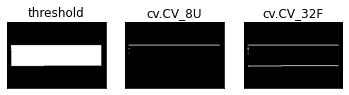

In [30]:
img = cv.imread("images/wood_planck.jfif")
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

th = cv.threshold(gray, 200, 255, cv.THRESH_BINARY_INV)[1]

# apply sobel kernel (wrong way)
sobely_8u = cv.Sobel(th, cv.CV_8U, 0, 1, ksize = 3)

# right way
sobely_32f = cv.Sobel(th, cv.CV_32F, 0, 1, ksize = 3)
sobely = cv.convertScaleAbs(sobely_32f)

plt.subplot(131), plt_img(th, "threshold")
plt.subplot(132), plt_img(sobely_8u, "cv.CV_8U")
plt.subplot(133), plt_img(sobely, "cv.CV_32F")
plt.show()

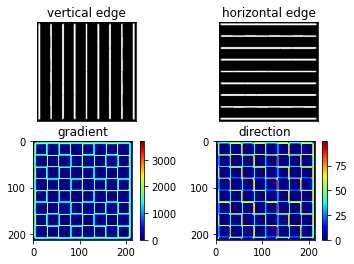

In [32]:
# combine both the x and y direction to form gradient and orientation map
img = cv.imread("images/chessboard.png", 0)

# sobel x and sobel y
sobelx = cv.Sobel(img, cv.CV_32F, 1, 0, ksize = -1)
sobelx_8u = cv.convertScaleAbs(sobelx)
sobely = cv.Sobel(img, cv.CV_32F, 0, 1, ksize = -1)
sobely_8u = cv.convertScaleAbs(sobely)

# combine x and y
gradient = cv.magnitude(sobelx, sobely)
direction = np.arctan2(sobelx, sobely) * (180 / np.pi) % 100

plt.subplot(221), plt_img(sobelx_8u, "vertical edge")
plt.subplot(222), plt_img(sobely_8u, "horizontal edge")
plt.subplot(223), plt.imshow(gradient, cmap = "jet"), plt.title("gradient"),
plt.colorbar()
plt.subplot(224), plt.imshow(direction, cmap = "jet"), plt.title("direction"),
plt.colorbar()

plt.show()

## Laplacian (second order derivatives)


In [34]:
img = cv.imread("images/lena.jfif", 0)

# blur
blur = cv.GaussianBlur(img, (5, 5), 0)
LoG = cv.Laplacian(blur, cv.CV_16S)
LoG = cv.convertScaleAbs(LoG)

cv.imshow("grayscale", img)
show_img("LoG", LoG)

## Canny edge detector
- lower the number of false positives, enhance the edge detection accuracy.
- Flexible.



### Canny algorithm
    * Gaussian blurring (SCS)
    * Sobel x and y
    * non-max suppression
    * Hysteresis threshold
    
    best formula = th2/th1 * (2-5)

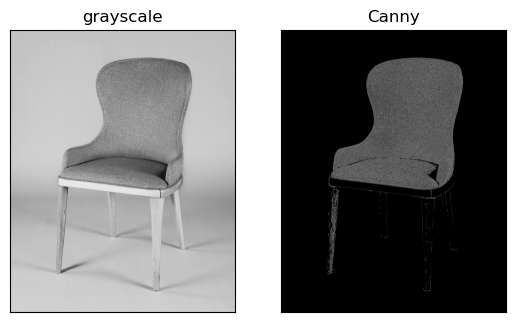

In [6]:
img = cv.imread("images/chair.jpg", 0)

edge = cv.Canny(img, 100, 300)

plt.subplot(121), plt_img(img, "grayscale")
plt.subplot(122), plt_img(edge, "Canny")
plt.show()

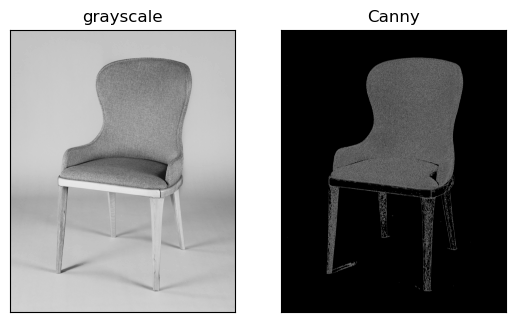

In [7]:
img = cv.imread("images/chair.jpg", 0)

edge = cv.Canny(img, 30, 150)

plt.subplot(121), plt_img(img, "grayscale")
plt.subplot(122), plt_img(edge, "Canny")
plt.show()

## Exercise
Create a trackbar that control the hysterisis thresholds and display the resulting images from the changes in the
thresholds

In [8]:
img = cv.imread("images/bulbs.jpg")
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

wn = "Canny edge"
trackbarName = "low Threshold"
ratio = 2.5
ksize = 3

def cannyThresh(val):
    edge = cv.Canny(gray, val, ratio * val, apertureSize = ksize)
    # create color edge
    mask = edge != 0
    res = img * (mask[:, :, None].astype(np.uint8))
    cv.imshow(wn, res)
    
cv.namedWindow(wn)
cv.createTrackbar(trackbarName, wn, 0, 100, cannyThresh)

cv.waitKey(0)
cv.destroyAllWindows()

In [9]:
# automatic Canny
def canny_auto(img, method, sigma=0.33):
    """Args:
    img: grayscale
    method: median, triangle and otsu
    sigma = 0.33 (default)"""
    if method == "median":
        Th = np.median(img)
        
    elif method == "triangle":
        Th = cv.threshold(img, 0, 255, cv.THRESH_TRIANGLE)[0]
        
    elif method == "otsu":
        Th = cv.threshold(img, 0, 255, cv.THRESH_OTSU)[0]
        
    else:
        raise Exception("method specified not available!")
        
    lowThresh = (1-sigma) * Th
    highThresh = (1+sigma) * Th
    
    return cv.Canny(img, lowThresh, highThresh)

### Contours
Curve joining all the points along the object boundary.

In [10]:
rect = np.zeros((255, 255), dtype = np.uint8)

cv.rectangle(rect, (25, 25), (231, 231), 255, -1)

contours, _ = cv.findContours(rect, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

In [11]:
len(contours)

1

In [12]:
contours[0]

array([[[ 25,  25]],

       [[ 25, 231]],

       [[231, 231]],

       [[231,  25]]], dtype=int32)

In [13]:
rect_bgr = cv.cvtColor(rect, cv.COLOR_GRAY2BGR)
cv.drawContours(rect_bgr, contours,-1, (0, 255, 0), 2)

show_img("contour", rect_bgr)

In [14]:
img = cv.imread("images/monitor.jfif")
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# Binary Threshold
th = cv.threshold(gray, 200, 255, cv.THRESH_BINARY_INV)[1]

# find contours
contours, _ = cv.findContours(th, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

# draw contours
img_copy = img.copy()
cv.drawContours(img_copy, contours, -1, (0, 255, 0), 1)

show_img("contours", img_copy)

In [15]:
len(contours)

12

In [16]:
# one of the single way: retain just the contours with the largest number of points
length = [len(c) for c in contours]
cnt = contours[np.argmax(length)]

img_copy = img.copy()
cv.drawContours(img_copy, [cnt], -1, (0, 255, 0), 1)

show_img("contours", img_copy)

## Contour features
- centroid
- area
- perimeter
- bounding box

In [17]:
M = cv.moments(cnt)
print(M)

{'m00': 37113.5, 'm10': 3913689.5, 'm01': 3849569.1666666665, 'm20': 529272493.25, 'm11': 402572898.125, 'm02': 519454930.25, 'm30': 80631725758.65001, 'm21': 53484537787.45, 'm12': 53828827220.55, 'm03': 80175930424.35, 'mu20': 116566456.29821026, 'mu11': -3371527.140929699, 'mu02': 120161337.11136603, 'mu30': 234618732.78678894, 'mu21': -702775455.4171028, 'mu12': -249269762.75935364, 'mu03': 1368584318.4292145, 'nu20': 0.08462716040157804, 'nu11': -0.0024477261916909816, 'nu02': 0.08723704119285126, 'nu30': 0.0008841641534443626, 'nu21': -0.002648419664618219, 'nu12': -0.0009393767758931957, 'nu03': 0.005157530180767104}


In [18]:
cx = int(M['m10'] / M['m00'])
cy = int(M['m01'] / M['m00'])

print(f"The centroid of contourL {(cx,cy)}")

The centroid of contourL (105, 103)


In [19]:
area = cv.contourArea(cnt)
peri = cv.arcLength(cnt, True)
print(f"The area of contour: {area}")
print("The perimeter of contour: {}".format(round(peri, 3)))

The area of contour: 37113.5
The perimeter of contour: 1056.777


## contour properties
$$aspect \ ratio = \frac{width}{height}$$

$$circularity = \frac{4 \times \pi \times A}{Perimeter^2}$$

In [20]:
img = cv.imread("images/remote-controller.webp")

show_img("aircond controller", img)

In [21]:
# resize -> grayscale -> bilateral -> Canny -> findContour -> Contour features
# sort the contour with respect to area in descending order
factor = 300 / img.shape[1]
img = cv.resize(img, None, fx = factor, fy = factor)
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

blur = cv.bilateralFilter(gray, 7, 19, 13)
edge = canny_auto(blur, method = "triangle")

show_img("edges", edge)

In [22]:
contours, _ = cv.findContours(edge, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

cnts = sorted(contours, key = cv.contourArea, reverse = True)[:5]
screen = None
img_copy = img.copy()

# rectangular contour
for c in cnts:
    peri = cv.arcLength(c, True)
    approx = cv.approxPolyDP(c, 0.1 * peri, True)
    
    if len(approx) == 4:
        screen = c
        break
    
cv.drawContours(img_copy, [screen], -1, (0, 255, 0), 2)
show_img("contour", img_copy)

In [ ]:
# define the low and high threshold for red color in HSV color space
redLow1 = (0, 90, 40)
redHigh1 = (10, 255, 210)

redLow2 = (170, 90, 40)
redHigh2 = (179, 255, 210)

cap = cv.VideoCapture(0)

if not cap.isOpened():
    sys.exit("No webcam detected!")
    
kernel = np.ones((3, 3), dtype = np.uint8)
fixed_width = min_area = 500
factor = fixed_width / cap.get(3)    # frame width

while True:
    ret, frame = cap.read()
    
    if not ret:
        print("frame not received")
        break
    
    # resize -> blur -> change to HSV -> color inRange ->morphology
    resize = cv.resize(frame, None, fx = factor, fy = factor)
    blur = cv.GaussianBlur(resize, (5, 5), 0)
    img_hsv = cv.cvtColor(blur, cv.COLOR_BGR2HSV)
    
    # color segmentation
    mask1 = cv.inRange(img_hsv, redLow1, redHigh1)
    mask2 = cv.inRange(img_hsv, redLow2, redHigh2)
    mask = cv.add(mask1, mask2)
    
    # morphological opening (remove noise)
    mask = cv.morphologyEx(mask, cv.MORPH_OPEN, kernel, iterations = 2)
    
    # find contour
    contours = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    cnts = contours[0]
    bbs = []
    
    # filter out the smaller object and draw bounding box
    for c in cnts:
        area = cv.contourArea(c)
        if area > min_area:
            bb = cv.boundingRect(c)
            bbs.append(bb)
            
    for bb in bbs:
        x, y, w, h = bb
        cv.rectangle(resize, (x, y), (x+w, y+h), (0, 255, 0), 2)
        
    cv.imshow("red object", resize)
    k = cv.waitKey(1) & 0xFF
    if k == 27:
        break
        
cv.destroyAllWindows()
cap.release()

## Exercise

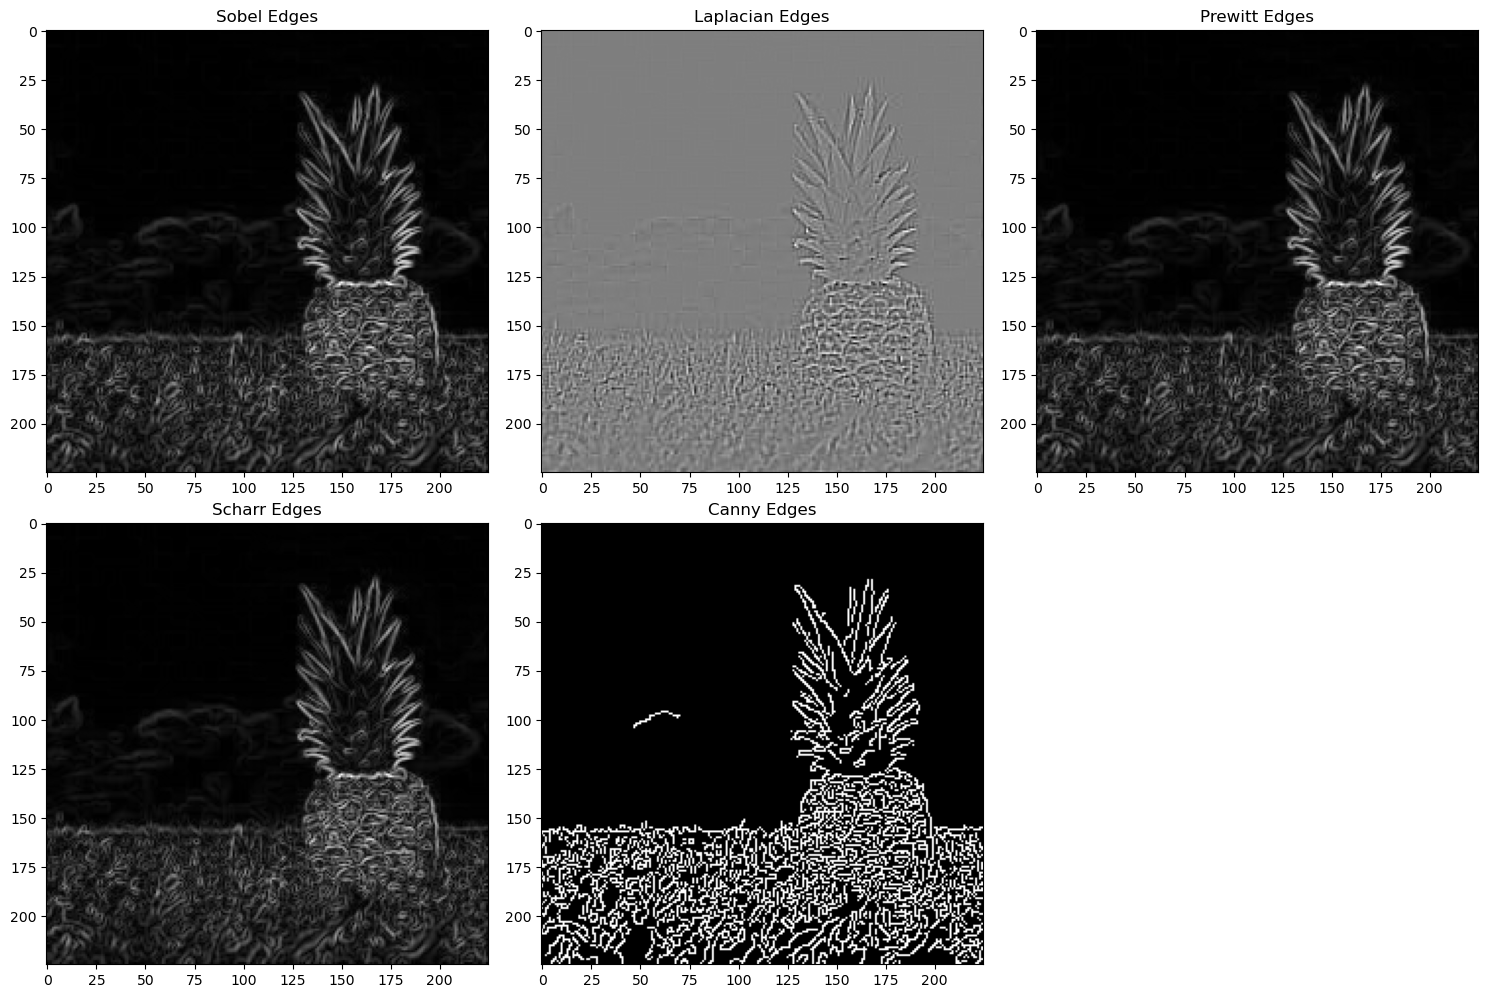

In [6]:
##Question 1
import cv2
import matplotlib.pyplot as plt

# Load the image
image_path = 'images/pineapple.jfif'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply edge detection techniques
sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
sobel_edges = cv2.magnitude(sobel_x, sobel_y)

laplacian_edges = cv2.Laplacian(image, cv2.CV_64F, ksize=3)

prewitt_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
prewitt_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
prewitt_edges = cv2.magnitude(prewitt_x, prewitt_y)

scharr_x = cv2.Scharr(image, cv2.CV_64F, 1, 0)
scharr_y = cv2.Scharr(image, cv2.CV_64F, 0, 1)
scharr_edges = cv2.magnitude(scharr_x, scharr_y)

canny_edges = cv2.Canny(image, threshold1=100, threshold2=200)

# Display the results
plt.figure(figsize=(15, 10))

plt.subplot(231)
plt.imshow(sobel_edges, cmap='gray')
plt.title('Sobel Edges')

plt.subplot(232)
plt.imshow(laplacian_edges, cmap='gray')
plt.title('Laplacian Edges')

plt.subplot(233)
plt.imshow(prewitt_edges, cmap='gray')
plt.title('Prewitt Edges')

plt.subplot(234)
plt.imshow(scharr_edges, cmap='gray')
plt.title('Scharr Edges')

plt.subplot(235)
plt.imshow(canny_edges, cmap='gray')
plt.title('Canny Edges')

plt.tight_layout()
plt.show()


## Comment

Laplacian Edges:
Sensitive to noise, which can lead to false positives.

Canny Operator:
The result is best among other methods.It produces well-defined and thin edges while suppressing noise.

Sobel Operator,Prewitt Operator and Scharr Operator:Produce similar results

In [18]:
##Question 2
import cv2

# Load the image
image_path = 'images/electronic.jfif'
image = cv2.imread(image_path)
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply thresholding to create a binary mask
ret, thresholded = cv2.threshold(gray_image, 200, 255, cv2.THRESH_BINARY)

# Find contours in the binary image
contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw bounding boxes around detected objects
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Draw a green bounding box

# Display the image with bounding boxes
cv2.imshow('Detected Object', image)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [20]:
##Question 3
import cv2
import numpy as np

# Load the image
image_path = 'images/clock.jpg'
image = cv2.imread(image_path)
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Canny edge detection
edges = cv2.Canny(gray_image, threshold1=50, threshold2=150)

# Find contours in the edge-detected image
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Initialize variables to store clock contour and its properties
clock_contour = None
max_area = 0

# Iterate through contours to find the clock contour
for contour in contours:
    area = cv2.contourArea(contour)
    if area > max_area:
        max_area = area
        clock_contour = contour

# Draw a green circle around the clock
if clock_contour is not None:
    (x, y), radius = cv2.minEnclosingCircle(clock_contour)
    center = (int(x), int(y))
    radius = int(radius)
    cv2.circle(image, center, radius, (0, 255, 0), 2)

# Display the image with the green circle
cv2.imshow('Clock Detection', image)
cv2.waitKey(0)
cv2.destroyAllWindows()